In [18]:
import coiled

In [19]:
coiled.create_software_environment(
    name="airflow",
    account="coiled-examples",
    conda="/Users/rpelgrim/Documents/git/coiled-resources/airflow-with-coiled/environment-cluster.yml"
)

Creating new software environment
Creating new ecr build
STEP 1: FROM coiled/default:sha-6b4e896
STEP 2: COPY environment.yml environment.yml
--> 3547b66593f
STEP 3: RUN conda env update -n coiled -f environment.yml     && rm environment.yml     && conda clean --all -y     && echo "conda activate coiled" >> ~/.bashrc
Solving environment: ...working... done

double-conversion-3. | 235 KB    | ########## | 100% 
pysocks-1.7.1        | 31 KB     | ########## | 100% 
yaml-0.2.5           | 75 KB     | ########## | 100% 
libgomp-11.2.0       | 427 KB    | ########## | 100% 
readline-8.1         | 362 KB    | ########## | 100% 
pandas-1.3.4         | 9.6 MB    | ########## | 100% 
_openmp_mutex-4.5    | 22 KB     | ########## | 100% 
click-8.0.3          | 79 KB     | ########## | 100% 
sortedcontainers-2.4 | 26 KB     | ########## | 100% 
thrift-0.11.0        | 107 KB    | ########## | 100% 
nest-asyncio-1.5.1   | 10 KB     | ########## | 100% 
pycparser-2.21       | 94 KB     | ########## 

In [3]:
cluster = coiled.Cluster(
    name="airflow-coiled-def",
    software="coiled-examples/airflow",
    n_workers=40,
    shutdown_on_close=False,
    scheduler_options={'idle_timeout':'2 hours'},
    backend_options={'spot':'True'},
)

/Users/rpelgrim/mambaforge/envs/airflow-new/lib/python3.9/site-packages/rich/live.py:229: UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')


Using existing cluster: 'airflow-coiled-def'

## Getting Cluster TLS setting

In [50]:
cluster.security

AttributeError: require_encryption

GatewaySecurity<...>

In [4]:
from distributed import Client
client = Client(cluster)
client

/Users/rpelgrim/mambaforge/envs/airflow-new/lib/python3.9/site-packages/distributed/client.py:1128: VersionMismatchWarning: Mismatched versions found

+---------+---------------+---------------+---------------+
| Package | client        | scheduler     | workers       |
+---------+---------------+---------------+---------------+
| msgpack | 1.0.3         | 1.0.2         | 1.0.2         |
| python  | 3.9.7.final.0 | 3.9.0.final.0 | 3.9.0.final.0 |
+---------+---------------+---------------+---------------+
Notes: 
-  msgpack: Variation is ok, as long as everything is above 0.6
  warnings.warn(version_module.VersionMismatchWarning(msg[0]["warning"]))


<Client: 'tls://10.4.1.74:8786' processes=40 threads=80, memory=306.68 GiB>

In [5]:
import dask.dataframe as dd

In [6]:
ddf = dd.read_parquet(
    's3://coiled-datasets/github-archive/github-archive-2015.parq/',
    storage_options={"anon": True, 'use_ssl': True},
    compression='lz4',
)

In [7]:
ddf.head()

,user,repo,created_at,message,author
0,soumith,soumith/fbcunn,2015-01-01T01:00:00Z,"back to old structure, except lua files moved out",Soumith Chintala
1,soumith,soumith/fbcunn,2015-01-01T01:00:00Z,...,Soumith Chintala
2,soumith,soumith/fbcunn,2015-01-01T01:00:00Z,...,Soumith Chintala
3,soumith,soumith/fbcunn,2015-01-01T01:00:00Z,...,Soumith Chintala
4,radix,radix/effect,2015-01-01T01:00:00Z,put the auto-generated API docs in the reposit...,Christopher Armstrong


These are only PushEvents.

Let's do a large-scale computation that will bring down a smaller value that we can then continue processing without Coiled. For example, getting the number of PushEvents per user.

We can then calculate some summary statistics in one task.

And create some visualisations in another task.

Nothing too fancy. Let's publish and then see if it gets traffic.


1. Large computation on Coiled cluster
2. Get summary statistics (mean, )
3. Plot something and save to file.
4. Get user and author names of 1% most active users and save to file.

In [8]:
user_counts = ddf.user.value_counts().compute()

In [9]:
sum_stat = user_counts.describe()

In [10]:
sum_stat

count    1.641819e+06
mean     3.572855e+01
std      9.390722e+02
min      1.000000e+00
25%      2.000000e+00
50%      7.000000e+00
75%      2.300000e+01
max      1.125856e+06
Name: user, dtype: float64

In [11]:
sum_stat.to_csv('usercounts_sum_stat.csv')

In [12]:
user_counts

mirror-updates    1125856
KenanSulayman      166138
greatfirebot       148132
markkcc            118305
rydnr               95574
                   ...   
lukjanov                1
mikkeluk                1
dimakrivolap            1
kalliplokime            1
boliveirageo            1
Name: user, Length: 1641819, dtype: int64

In [20]:
user_counts.std()

939.0722195043717

In [14]:
len(user_counts)

1641819

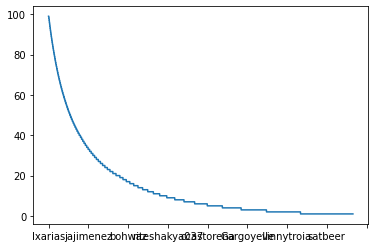

In [15]:
user_counts[user_counts < 100].plot();

In [16]:
import matplotlib.pyplot as plt

In [37]:
import numpy as np

In [42]:
data = np.arange(1,20)

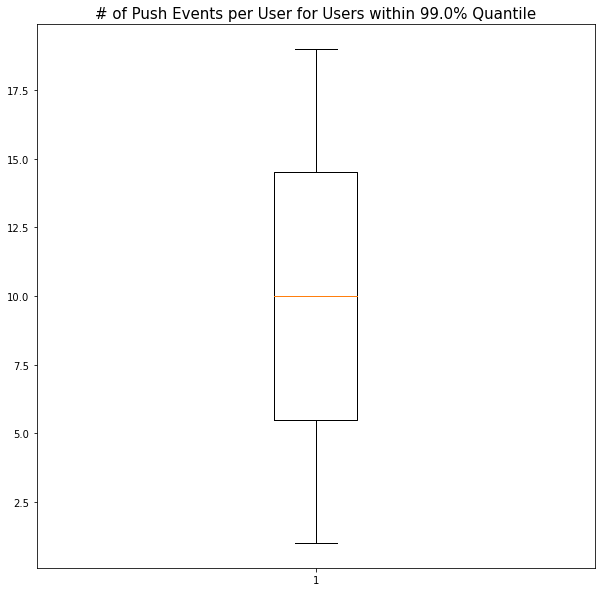

In [43]:
fig, ax = plt.subplots(figsize=(10,10))
quantile = 0.99

plt.title(f'# of Push Events per User for Users within {quantile*100}% Quantile', fontsize=15)

plt.boxplot(
    x=data,
)

plt.savefig(f'boxplot_{quantile*100}quantile.jpg')

In [23]:
storage_directory = ""

In [27]:
def transform():
    """
    Perform heavy computation on a large-scale dataset (~70GB) on a Coiled cluster.
    Provisioning cluster resources takes ~2 minutes.
    Returns a local pandas Series containing the number of entries (PushEvents) per user.
    """

    # # Create and connect to Coiled cluster using the default software environment
    # cluster = coiled.Cluster(
    #     n_workers=20, 
    #     name="airflow-task",
    #     software="coiled-examples/airflow",
    #     backend_options={'spot': 'True'},
    # )
    # client = Client(cluster)
    # print("Dashboard:", client.dashboard_link)

    # Read CSV data from S3
    ddf = dd.read_parquet(
        's3://coiled-datasets/github-archive/github-archive-2015.parq/',
        storage_options={"anon": True, 'use_ssl': True},
        blocksize="16 MiB",
        engine='fastparquet',
        compression='lz4',
    )

    # Compute result number of entries (PushEvents) per user
    result = ddf.user.value_counts().compute()

    # # Shutdown Coiled cluster
    # cluster.close()
    return result

In [24]:
def summarize(series):
    """
    Calculate summary statistics over the pandas Series of interest and save to CSV.
    Runs without Coiled.
    """
    # Get summary statistics
    sum_stats = series.describe()
    # Save to CSV
    sum_stats.to_csv(f'{storage_directory}usercounts_summary_statistics.csv')
    return sum_stats

In [26]:
def get_top_users(series):
    """
    Get user and author names of top 100 most active users and save to CSV.
    Runs without Coiled.
    """
    # Get top 100 most active users
    top_100 = series.head(100)

    # Store user + number of events to CSV
    top_100.to_csv(f'{storage_directory}top_100_users.csv')
    return top_100

In [34]:
def visualize(series, sum_stats):
    """
    Create visualisation plots and save as PNGs.
    Runs without Coiled.
    """
    # Create boxplot for users within 75, 90, 95, 99, and 99.9% quantiles
    for i in [0.75, 0.90, 0.95, 0.99, 0.999]:
        quantile = i
        fig, ax = plt.subplots(figsize=(10,10)) 
        plt.title(f'# of Push Events per User for Users within {quantile*100}% Quantile', fontsize=15)
        plt.boxplot(x=user_counts[user_counts < user_counts.quantile(0.999)])       
        plt.axhline(sum_stats['mean'], c='red', label='overall mean')
        plt.savefig(f'boxplot_{quantile*100}quantile.png')
        plt.close(fig)
        
    print('Visualisations have been created.')

In [28]:
# Call task functions in order
series = transform()

In [29]:
series

mirror-updates    1125856
KenanSulayman      166138
greatfirebot       148132
markkcc            118305
rydnr               95574
                   ...   
lukjanov                1
mikkeluk                1
dimakrivolap            1
kalliplokime            1
boliveirageo            1
Name: user, Length: 1641819, dtype: int64

In [30]:
stats = summarize(series)

In [31]:
top_100 = get_top_users(series)

In [35]:
viz = visualize(series, stats)

Visualisations have been created.


In [25]:
stats = summarize(user_counts)

In [15]:
import numpy as np 
import matplotlib.pyplot as plt

def visualize_dummy():
    """
    Create visualisation plots and save as PNGs.
    Runs without Coiled.
    """
    # Create boxplot for users within 75, 90, 95, 99, and 99.9% quantiles
    data = np.arange(1,20)
    #fig, ax = plt.subplots(figsize=(10,10)) 
    plt.title('# of Push Events per User for Users within % Quantile', fontsize=15)
    plt.boxplot(x=data)       
    #plt.axhline(sum_stats['mean'], c='red', label='overall mean')
    plt.savefig('test.png')
    plt.close()

    print('Visualisations have been created.')

In [16]:
visualize_dummy()

Visualisations have been created.


Visualisations have been created.


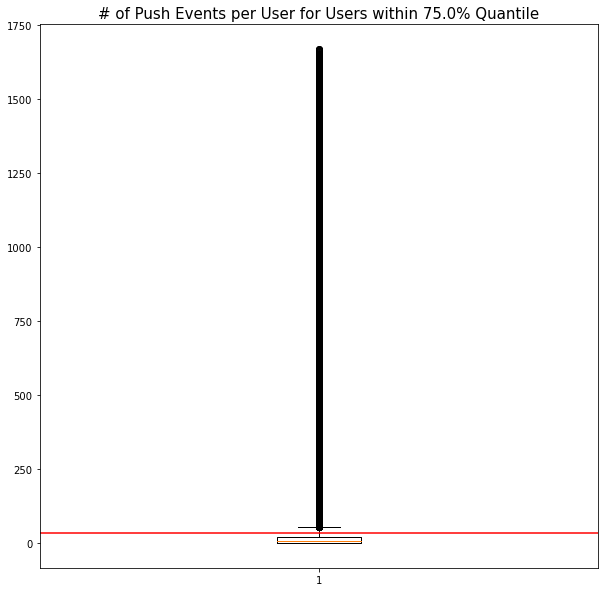

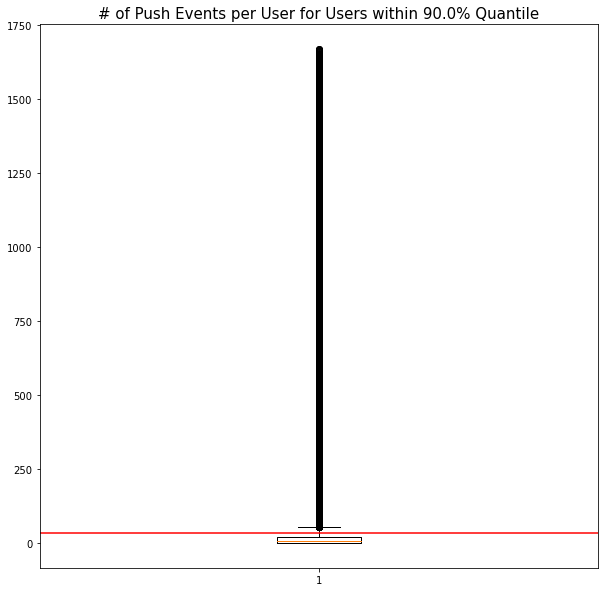

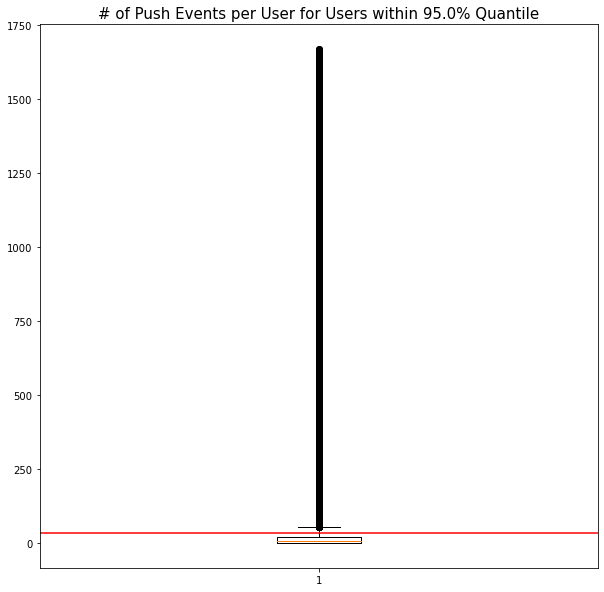

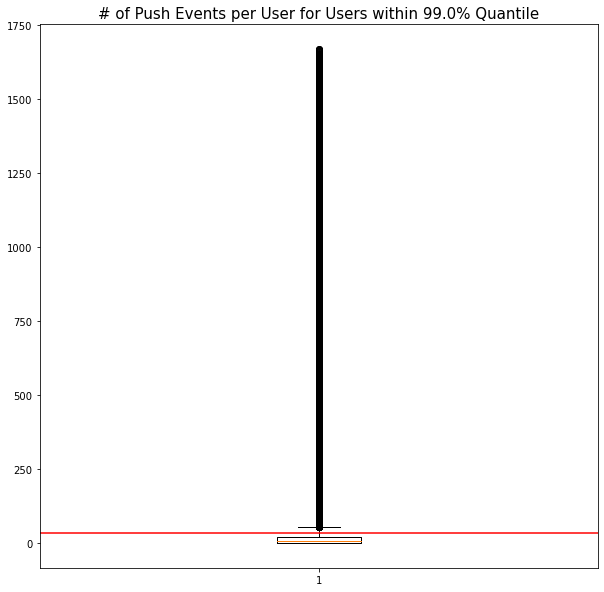

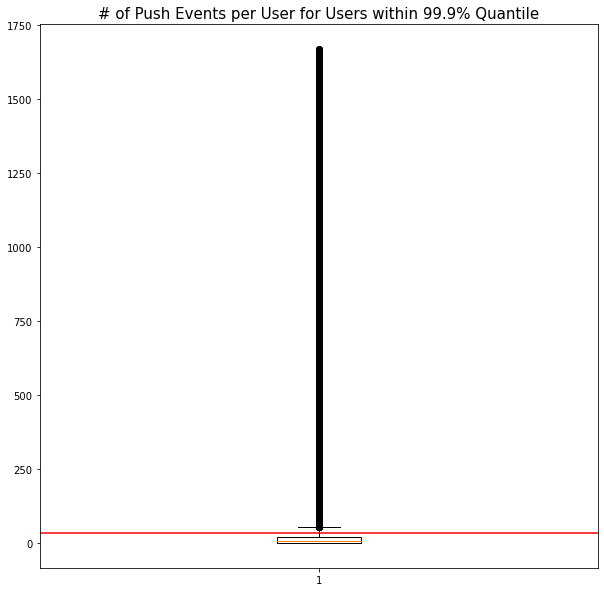

In [19]:
visualize(user_counts, sum_stat)

In [ ]:
for i in [0.75, 0.90, 0.95, 0.99, 0.999]:
    quantile = i
    fig, ax = plt.subplots(figsize=(10,10)) 
    plt.title(f'# of Push Events per User for Users within {quantile*100}% Quantile', fontsize=15)
    sns.boxplot(
        data=user_counts[user_counts < user_counts.quantile(quantile)],
    )
    plt.axhline(sum_stat['mean'], c='red', label='overall mean')
    plt.legend()
    plt.savefig(f'boxplot_{quantile*100}quantile.jpg')

In [33]:
top_100 = user_counts.head(100)

In [ ]:
fig,ax = plt.subplots(figsize=(15,20))
sns.lineplot(data=top_100)
#top_100.plot()
plt.axhline(y=sum_stat['mean']);

In [29]:
sum_stat

count    1.641819e+06
mean     3.572855e+01
std      9.390722e+02
min      1.000000e+00
25%      2.000000e+00
50%      7.000000e+00
75%      2.300000e+01
max      1.125856e+06
Name: user, dtype: float64

In [28]:
sum_stat['count']

1641819.0

In [14]:
user_counts_1000 = user_counts[user_counts > 1000]

In [15]:
len(user_counts_1000)

4239

In [20]:
user_counts_1000.index

Index(['mirror-updates', 'KenanSulayman', 'greatfirebot', 'markkcc', 'rydnr',
       'asfgit', 'diversify-exp-user', 'grid-bot', 'dsm-git',
       'openstack-gerrit',
       ...
       'dhanvi', 'sa2ajj', 'boost-commitbot', 'qnet-herwin', 'bm5w', 'Mischi',
       'lamagnifica', 'raffaellod', 'djcp', 'richelbilderbeek'],
      dtype='object', length=4239)

In [ ]:
ddf.user.value_counts().compute()

In [ ]:
ddf[ddf.author==""]